# Agent with Memory

- Author: [Hye-yoon Jeong](https://github.com/Hye-yoonJeong)
- Peer Review: 
- Proofread:
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb)

## Overview

This tutorial covers how to add an **in-memory checkpoint saver** to an agent. 

An **in-memory checkpoint saver** enables an agent to store previous interactions, allowing the agent to engage in multi-turn conversations in a coherent manner.

Also in this tutorial, we use `ToolNode` and `tools_condition` prebuilt in `LangGraph` instead of a customized tool node.

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Memory Saver](#memory-saver)
- [Configuration with RunnableConfig](#configuration-with-runnableconfig)
- [Inspecting State Snapshots](#inspecting-state-snapshots)

### References

- [LangGraph: MemorySaver](https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.memory.MemorySaver)
- [LangGraph: ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.ToolNode)
- [LangGraph: tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.tools_condition)
----

## Environment Setup

Setting up your environment is the first step. See the [Environment Setup guide](https://wikidocs.net/257836) for more details.

**[Note]**

`langchain-opentutorial` is a package of easy-to-use environment setup guidance, useful functions and utilities for tutorials. Check out the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial


[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain",
        "langchain_core",
        "langchain_community",
        "langchain_openai",
        "langgraph",
    ],
    verbose=False,
    upgrade=False,
)

In [3]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

You can set API keys in a .env file or set them manually.

**[Note]** If you’re not using the .env file, no worries! Just enter the keys directly in the cell below, and you’re good to go.

In [4]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        # "OPENAI_API_KEY": "",
        # "LANGCHAIN_API_KEY": "",
        # "TAVILY_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "Agent-with-Memory",
    }
)

Environment variables have been set successfully.


## Memory Saver

Without a memory to remember the **context**, an agent cannot engage in multi-turn interactions.

In this tutorial, we use LangGraph's `MemorySaver`, which stores checkpoints in memory.

By providing a `checkpointer` during graph compilation and a `thread_id` when calling a graph, the state is **automatically saved** after each step. The `thread_id` acts as a key for continuous graph execution.

Steps to use `MemorySaver`:
1) Create a `MemorySaver` checkpointer.

In [5]:
from langgraph.checkpoint.memory import MemorySaver

# Create a MemorySaver
memory = MemorySaver()

2) Define a graph.

In [6]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


########## 1. Define state ##########
# Define states to save after each step
class State(TypedDict):
    messages: Annotated[list, add_messages]


########## 2. Define and bind tools ##########
# Define tools
tool = TavilySearchResults(k=3)
tools = [tool]

# Define LLM
llm = ChatOpenAI(model="gpt-4o-mini")

# Bind LLM with tools
llm_with_tools = llm.bind_tools(tools)


########## 3. Define nodes ##########
# Create a state graph
graph_builder = StateGraph(State)


# Define and add a chatbot node
def chatbot(state: State):
    # Invoke and return messages
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

# Define and add a tool node
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# Add a conditional edge
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

########## 4. Add edges ##########
# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)

3) Compile the graph with the `checkpointer`.

In [7]:
# Compile a graph builder
graph = graph_builder.compile(checkpointer=memory)

4) Visualize the graph.

In [8]:
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph
from dataclasses import dataclass


# Define node styles to use for visualizing the graph
@dataclass
class NodeStyles:
    default: str = (
        "fill:#45C4B0, fill-opacity:0.3, color:#23260F, stroke:#45C4B0, stroke-width:1px, font-weight:bold, line-height:1.2"
    )
    first: str = (
        "fill:#45C4B0, fill-opacity:0.1, color:#23260F, stroke:#45C4B0, stroke-width:1px, font-weight:normal, font-style:italic, stroke-dasharray:2,2"
    )
    last: str = (
        "fill:#45C4B0, fill-opacity:1, color:#000000, stroke:#45C4B0, stroke-width:1px, font-weight:normal, font-style:italic, stroke-dasharray:2,2"
    )


# Define a function to visualize the graph
def visualize_graph(graph, xray=False):
    """
    Displays a visualization of the CompiledStateGraph object.

    This function converts the given graph object,
    if it is an instance of CompiledStateGraph, into a Mermaid-formatted PNG image and displays it.

    Args:
        graph: The graph object to be visualized. Must be an instance of CompiledStateGraph.

    Returns:
        None

    Raises:
        Exception: Raised if an error occurs during the graph visualization process.
    """
    try:
        # Visualize the graph
        if isinstance(graph, CompiledStateGraph):
            display(
                Image(
                    graph.get_graph(xray=xray).draw_mermaid_png(
                        background_color="white",
                        node_colors=NodeStyles(),
                    )
                )
            )
    except Exception as e:
        print(f"[ERROR] Visualize Graph Error: {e}")

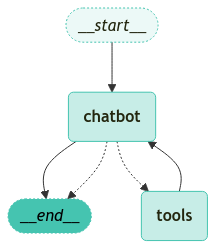

In [9]:
visualize_graph(graph)

## Configuration with `RunnableConfig`

Define a `RunnableConfig` object and set the `recursion_limit` and `thread_id` properties.

- `recursion_limit`: The maximum number of nodes the graph can visit. Exceeding this limit will trigger a `RecursionError`.
- `thread_id`: An ID to distinguish different sessions.

In [10]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=10,
    configurable={"thread_id": "1"},
)

In [11]:
# First question for {"thread_id": "1"}
question = "Hi! My name is Hannah. I run a YouTube channel. Nice to meet you!"

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hi Hannah! Nice to meet you too! That's awesome that you run a YouTube channel. What kind of content do you create?


In [12]:
# Second question for {"thread_id": "1"}
question = "Do you remember my name?"

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

================================== Ai Message ==================================

Yes, your name is Hannah! How can I assist you today?


Modify the `thread_id` in the `RunnableConfig` to see if the agent remembers the previous conversation.

In [13]:
config = RunnableConfig(
    recursion_limit=10,
    configurable={"thread_id": "2"},  # Change the thread_id
)

In [14]:
question = "Do you remember my name?"

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

================================== Ai Message ==================================

I don't have the ability to remember personal information or previous interactions. Each session is treated independently. How can I assist you today?


## Inspecting State Snapshots

A checkpoint (`snapshot`) stores:
 - the current state values
 - corresponding config
 - The **next** node to process (empty at the end).

Call `get_state(config)` to see a graph's `state` for a certain config.

In [15]:
config = RunnableConfig(
    configurable={"thread_id": "1"},
)
# Create a snapshot of the graph state
snapshot = graph.get_state(config)

In [16]:
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi! My name is Hannah. I run a YouTube channel. Nice to meet you!', additional_kwargs={}, response_metadata={}, id='f97ccf7d-a15d-4b02-9974-3908b008e181'), AIMessage(content="Hi Hannah! Nice to meet you too! That's awesome that you run a YouTube channel. What kind of content do you create?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 98, 'total_tokens': 127, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-4a48ff7d-4c42-4406-a65c-047e55d782bb-0', usage_metadata={'input_tokens': 98, 'output_tokens': 29, 'total_tokens': 127, 'input_token_details': {'audio': 0, 'cache_read': 0}, '

You can access the **configuration** with `snapshot.config`.

In [17]:
# Configuration of the snapshot
snapshot.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd6f6a-bfa9-6ae9-8004-08c865005c63'}}

You can access the **saved states** with `snapshot.value`.

In [18]:
# Values saved in the snapshot
snapshot.values

{'messages': [HumanMessage(content='Hi! My name is Hannah. I run a YouTube channel. Nice to meet you!', additional_kwargs={}, response_metadata={}, id='f97ccf7d-a15d-4b02-9974-3908b008e181'),
  AIMessage(content="Hi Hannah! Nice to meet you too! That's awesome that you run a YouTube channel. What kind of content do you create?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 98, 'total_tokens': 127, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-4a48ff7d-4c42-4406-a65c-047e55d782bb-0', usage_metadata={'input_tokens': 98, 'output_tokens': 29, 'total_tokens': 127, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_detail

You can use `snapshot.next` to see which **node** will be processed next. In this case, `snapshot.next` is empty since the graph reaches the **END** node.

In [19]:
# Next node
snapshot.next

()

Define custom functions to view the complete contents of `snapshot` and its metadata (`snapshot.metadata`).

In [20]:
import json


# Custom function to serialize non-JSON serializable objects
def custom_serializer(obj):
    if hasattr(obj, "__dict__"):
        return obj.__dict__
    elif isinstance(obj, (list, tuple)):
        return [custom_serializer(item) for item in obj]
    return str(obj)


# Custom function to print the snapshot
def pretty_print_snapshot(snapshot):
    try:
        snapshot_json = json.dumps(
            snapshot, indent=4, ensure_ascii=False, default=custom_serializer
        )
        print(snapshot_json)
    except Exception as e:
        print(f"Error formatting snapshot: {e}")

In [21]:
pretty_print_snapshot(snapshot)

[
    {
        "messages": [
            {
                "content": "Hi! My name is Hannah. I run a YouTube channel. Nice to meet you!",
                "additional_kwargs": {},
                "response_metadata": {},
                "type": "human",
                "name": null,
                "id": "f97ccf7d-a15d-4b02-9974-3908b008e181",
                "example": false
            },
            {
                "content": "Hi Hannah! Nice to meet you too! That's awesome that you run a YouTube channel. What kind of content do you create?",
                "additional_kwargs": {
                    "refusal": null
                },
                "response_metadata": {
                    "token_usage": {
                        "completion_tokens": 29,
                        "prompt_tokens": 98,
                        "total_tokens": 127,
                        "completion_tokens_details": {
                            "accepted_prediction_tokens": 0,
                    

In [22]:
pretty_print_snapshot(snapshot.metadata)

{
    "source": "loop",
    "writes": {
        "chatbot": {
            "messages": [
                {
                    "content": "Yes, your name is Hannah! How can I assist you today?",
                    "additional_kwargs": {
                        "refusal": null
                    },
                    "response_metadata": {
                        "token_usage": {
                            "completion_tokens": 16,
                            "prompt_tokens": 139,
                            "total_tokens": 155,
                            "completion_tokens_details": {
                                "accepted_prediction_tokens": 0,
                                "audio_tokens": 0,
                                "reasoning_tokens": 0,
                                "rejected_prediction_tokens": 0
                            },
                            "prompt_tokens_details": {
                                "audio_tokens": 0,
                                "c